In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from hyperbolicity.utils import construct_weighted_matrix
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
import numpy as np
import torch
from scGeneFit.functions import *
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
with open('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_zeisel.pkl', 'rb') as f:
    distances = pickle.load(f)

[X, Y, names]= load_example_data("zeisel")
N,d=X.shape
print(X.shape, Y.shape)
Y=Y-1 # to start from 0

print('nb classes level 0:',len(np.unique(Y[0])))
print('nb classes level 1:',len(np.unique(Y[1])))

(3005, 4000) (2, 3005)
nb classes level 0: 7
nb classes level 1: 48


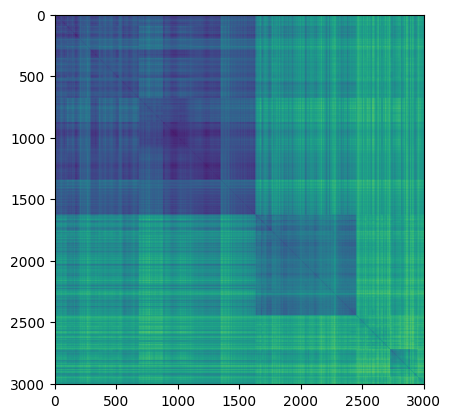

In [3]:
import torch
import pickle
import torch.nn.functional as F

def cosine_distance_matrix(X):
    X_normalized = F.normalize(X, p=2, dim=1)
    cosine_similarity = torch.mm(X_normalized, X_normalized.t())
    return 1 - cosine_similarity


X_torch = torch.from_numpy(X)
distance = cosine_distance_matrix(X_torch)
distance = distance.fill_diagonal_(0)
with open('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_zeisel.pkl', 'wb') as f:
    pickle.dump(distance, f)

plt.imshow(distance)

In [7]:
df = pd.read_csv('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_zeisel_2025-05-07_08-11-36/results.csv')
df.columns = df.columns.str.strip()
df.loc[df['mean_optim_distortion'].idxmin()]

learning_rate                 0.001000
distance_reg                  0.010000
scale_delta                  10.000000
epochs                     1000.000000
batch_size                   32.000000
n_batches                   100.000000
intermediate_distortion       0.154593
intermediate_l1               0.049134
mean_optim_l1                 0.090132
min_optim_l1                  0.081300
std_optim_l1                  0.007560
mean_optim_distortion         0.357263
min_optim_distortion          0.309162
std_optim_distortion          0.011978
epochs_reached             1000.000000
Name: 31, dtype: float64

In [8]:
data = torch.load('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_zeisel_2025-05-07_08-11-36/lr_0.01_dr_0.1_sd_1.0_epoch_1000_batch_32_n_batches_100.pt')
best_weights = data['weights']
num_nodes = distances.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
distance_optimized = construct_weighted_matrix(best_weights, num_nodes, edges)

In [9]:
new_row = torch.full((1, distance_optimized.shape[1]), 20)
distance_optimized_node = torch.cat((distance_optimized, new_row), dim=0)
new_column = torch.full((distance_optimized_node.shape[0], 1), 20)
distance_optimized_node = torch.cat((distance_optimized_node, new_column), dim=1)
distance_optimized_node[-1,-1] = 0

In [10]:
tree = gromov_tree(distance_optimized_node.numpy(), num_nodes)

In [11]:
tree_distance = tree[:-1, :-1]

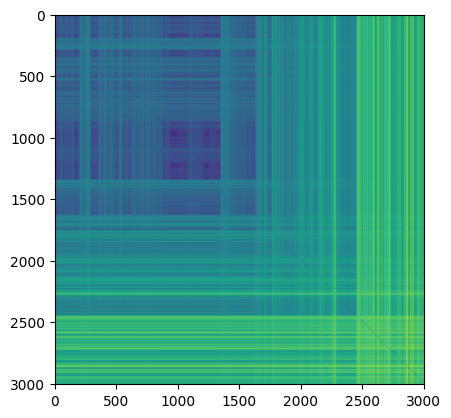

In [12]:
plt.imshow(tree_distance)

In [13]:
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm) 
    return cm[row_ind, col_ind].sum() / np.sum(cm)

In [14]:
clustering = AgglomerativeClustering(n_clusters=13).fit(X)
labels = clustering.labels_
ari = adjusted_rand_score(Y[1], clustering.labels_)
print('Adjusted Rank Index no optimization', ari)

Z1 = linkage(distances, method='complete')
cluster_labels1 = fcluster(Z1, t=13, criterion='maxclust') 
print(clustering_accuracy(Y[1], cluster_labels1))

Adjusted Rank Index no optimization 0.23363033340500586


/tmp/ipykernel_3984486/714141019.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = linkage(distances, method='complete')


0.2795341098169717


In [15]:
clustering = AgglomerativeClustering(n_clusters=13).fit(tree_distance)
labels = clustering.labels_
ari = adjusted_rand_score(Y[1], clustering.labels_)
print('Adjusted Rank Index no optimization', ari)

/share/home/houedry/anaconda3/envs/hyperenv_py311/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Adjusted Rank Index no optimization 0.09508319930304988


In [16]:
Z2 = linkage(tree_distance, method='complete')
cluster_labels2 = fcluster(Z2, t=13, criterion='maxclust') 
print(clustering_accuracy(Y[1], cluster_labels2))

/tmp/ipykernel_3984486/1965532180.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = linkage(tree_distance, method='complete')


0.22229617304492513


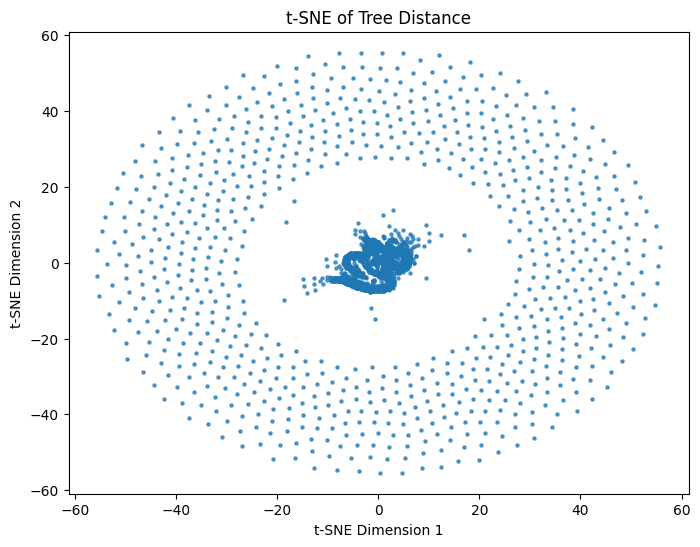

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set t-SNE initialization to 'random' since 'pca' cannot be used with precomputed metric
tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random')
tree_distance_tsne = tsne.fit_transform(tree_distance)

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tree_distance_tsne[:, 0], tree_distance_tsne[:, 1], s=5, alpha=0.7)
plt.title('t-SNE of Tree Distance')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


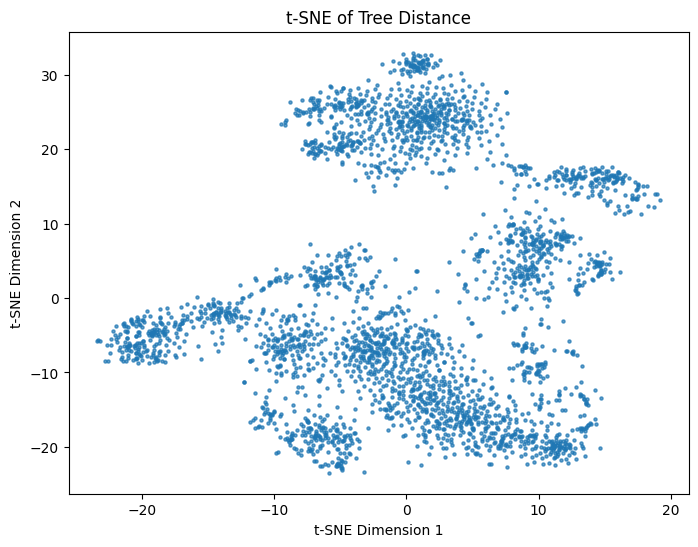

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set t-SNE initialization to 'random' since 'pca' cannot be used with precomputed metric
tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random')
tree_distance_tsne = tsne.fit_transform(distance)

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tree_distance_tsne[:, 0], tree_distance_tsne[:, 1], s=5, alpha=0.7)
plt.title('t-SNE of Tree Distance')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
